#User-base collaborative filtering on Movielens

#ДЗ1
*Курсив*## Теор факты
𝑠(𝑢, 𝑣) - мера похожести между пользователями;
$N(u)=\{v \in U\backslash\{u\} \mid s(u, v)>\alpha\}$

Оценка рейтинга, как среднее по соседям с весами:

$$
\hat{r}_{u i}=\frac{\sum_{v \in N(u)} s(u, v) r_{v i}}{\sum_{v \in N(u)}|s(u, v)|}
$$

Проблема: разные пользователи ставят рейтинги в разной шкале, поэтому сделаем поправку на средний рейтинг пользователя
$$
\hat{r}_{u i}=\bar{r}_u+\sigma_u \frac{\sum_{v \in N(u)} s(u, v)\left(r_{v i}-\bar{r}_v\right) / \sigma_v}{\sum_{v \in N(u)}|s(u, v)|} \quad \sigma_u=\sqrt{\frac{1}{\left|I_u\right|} \sum_{i \in I_u}\left(r_{u i}-r_u\right)^2}
$$

### Import useful requirements

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip
    !unzip recsys.zip

### Import requirements

In [ ]:
import os
import sys
import typing as tp

import joblib
import numpy as np
import pandas as pd
import tqdm.notebook
from recsys.datasets import ml1m, ml100k
from sklearn.preprocessing import LabelEncoder

### Dataset upload\

In [ ]:
%load_ext autoreload
%autoreload 2

Will use movielens dataset

In [ ]:
ratings, movies = ml100k.load()

Download data 100.2%
Successfully downloaded ml-100k.zip 4924029 bytes.
Unzipping the ml-100k.zip zip file ...


In [ ]:
ratings['userid'].max()

943

In [ ]:
movies

,itemid,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


from matplotlib import pyplot as plt
movies['itemid'].plot(kind='hist', bins=20, title='itemid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['itemid']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'itemid'}, axis=1)
              .sort_values('itemid', ascending=True))
  xs = counted['itemid']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = movies.sort_values('itemid', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('itemid')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
movies['itemid'].plot(kind='line', figsize=(8, 4), title='itemid')
plt.gca().spines[['top', 'right']].set_visible(False)

### Preprocessing

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings["userid"].unique())
    items = sorted(ratings["itemid"].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())

    return ratings, uencoder, iencoder

In [ ]:
# create the encoder
ratings, uencoder, iencoder = ids_encoder(ratings)

In [ ]:
def normalize_rating(ratings: pd.DataFrame) -> pd.DataFrame:
    """Normalize ratings by user"""
    # calculate mean for every user
    mean = ratings.groupby(by="userid", as_index=False)["rating"].mean()
    norm_ratings = pd.merge(ratings, mean, suffixes=("", "_mean"), on="userid")

    # normalize each rating by substracting the mean rating of the corresponding user
    norm_ratings["norm_rating"] = norm_ratings["rating"] - norm_ratings["rating_mean"]

    return norm_ratings[ratings.columns.tolist() + ["norm_rating"]]
def test_normalize():
    test_df = pd.DataFrame(
        {
            "userid": [0, 0, 0, 1, 1],
            "itemid": [0, 1, 2, 1, 3],
            "rating": [2, 2, 5, 5, 5],
        }
    )

    expected = pd.DataFrame(
        {
            "userid": [0, 0, 0, 1, 1],
            "itemid": [0, 1, 2, 1, 3],
            "rating": [2, 2, 5, 5, 5],
            "norm_rating": [-1, -1, 2, 0, 0],
        }
    )

    assert (
        test_df.shape[0] == expected.shape[0]
    ), "Number of user-item interactions is different"
    assert test_df.shape[1] + 1 == expected.shape[1], "Number of columns is incorrect"
    assert (normalize_rating(test_df) == expected).all().all(), "Result is incorrect"


test_normalize()

In [ ]:
norm_ratings_ml100k = normalize_rating(ratings)
np_ratings_ml100k = norm_ratings_ml100k.to_numpy()
norm_ratings_ml100k.head()
#np_ratings_ml100k

,userid,itemid,rating,norm_rating
0,0,0,5,1.389706
1,0,1,3,-0.610294
2,0,2,4,0.389706
3,0,3,3,-0.610294
4,0,4,3,-0.610294


### Функции сходства

In [ ]:
def cosine(x: np.array, y: np.array) -> float:
    if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
        return 0
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [ ]:
def test_cosine():
  a = np.array([1,2,3,4,5])
  b = np.array([0,0,0,0,1])
  print(cosine(a,b))
test_cosine()

0.674199862463242


$$scalar_product(x,y) = \sum_{i=1}^n x_i y_i$$

In [ ]:
def scalar_product(x: np.array, y: np.array) -> float:
  assert x.shape == y.shape
  return np.dot(x, y)

Pearson correlation is from -1 to 1, so absolute values will be different for same users, but it will reflect other type of relations between users (or items).

$$
\bar{x} = \frac{1}{n} \sum_{j = 1}^n x_j ;\ \bar{y} = \frac{1}{n} \sum_{j = 1}^n y_j \\
\text{corr}(x, y) = \dfrac{\sum_{i = 1}^n (x_i - \bar{x}) (y_i - \bar{y})}{\sqrt{\sum_{i = 1}^n (x_i - \bar{x})^2 \sum_{i = 1}^n (y_i - \bar{y})^2}}
$$

In [ ]:
def jaccard_similarity(set_A, set_B):
  return len(np.intersect1d(set_A , set_B))/len(np.union1d(set_A, set_B))

def test_jaccard_similarity():
  a = np.array([1,2,3,4,5])
  b = np.array([4,5,6,7,8,5])
  print(jaccard_similarity(a,b))
test_jaccard_similarity()

0.25


##Часть 2
Реализовать схемы колаборативной фильтрации на основе похожестей (там далее есть вариант++ ):
1. Простое усреднение по ближайшим соседям (10 баллов): User2User.predict
2. Усреднение с учётом коррекции среднего (10 баллов): User2User.predict_with_correction

---








## Часть 3
Разделите датасет movielens на тренировочную и валидационную части. Постройте рекомендации для пользователей из валидационной части (40 баллов)

Выберите от 10 до 50 своих любимых фильмов (можно экспортировать из Кинопоиска или IMDB) и посчитайте топ-10 рекомендаций по каждому из 6 методов (полученных обхединением вариантов выше) (40 баллов)

Построим инфографикку.

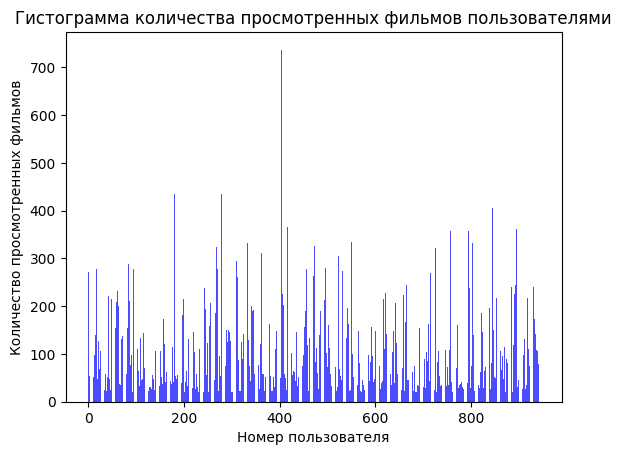

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = ratings

user_movie_counts = df.groupby('userid')['itemid'].count()


plt.bar(user_movie_counts.index, user_movie_counts.values, color='blue', alpha=0.7)
plt.xlabel('Номер пользователя')
plt.ylabel('Количество просмотренных фильмов')
plt.title('Гистограмма количества просмотренных фильмов пользователями')
plt.show()

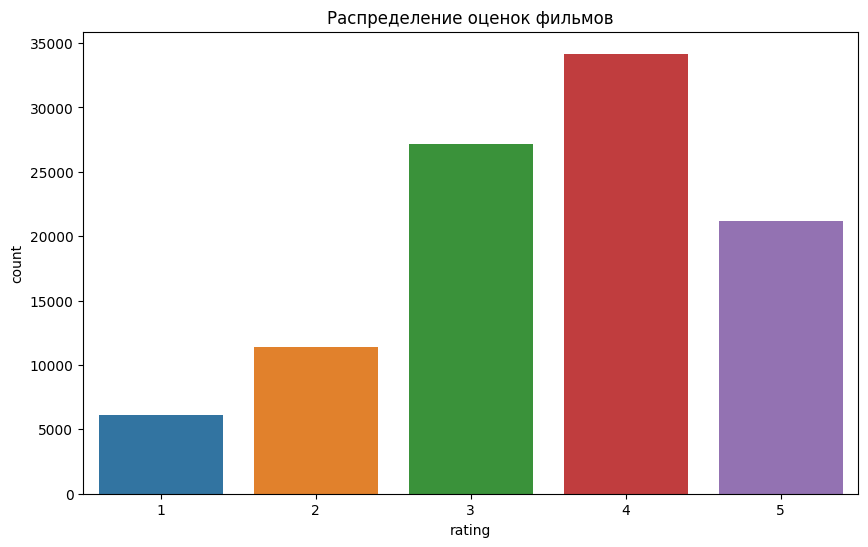

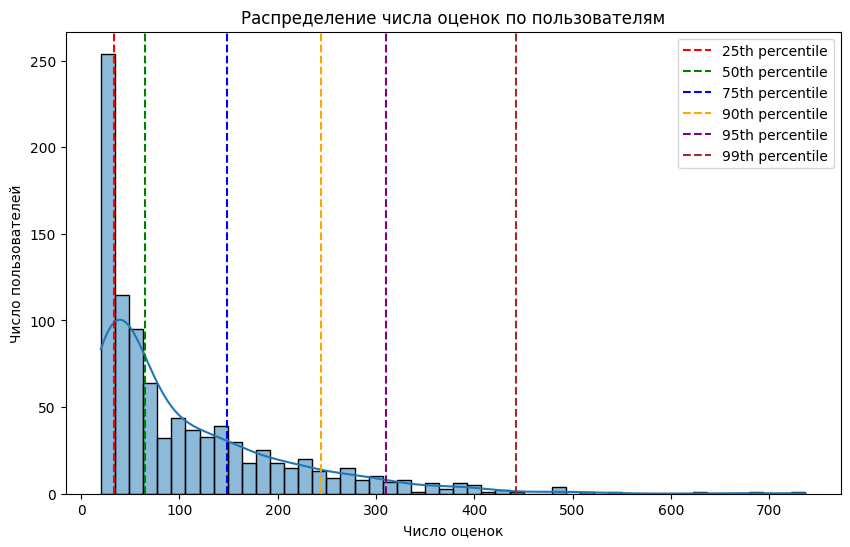

[33.0, 65.0, 148.0, 244.4000000000002, 310.5999999999999, 442.54000000000053]


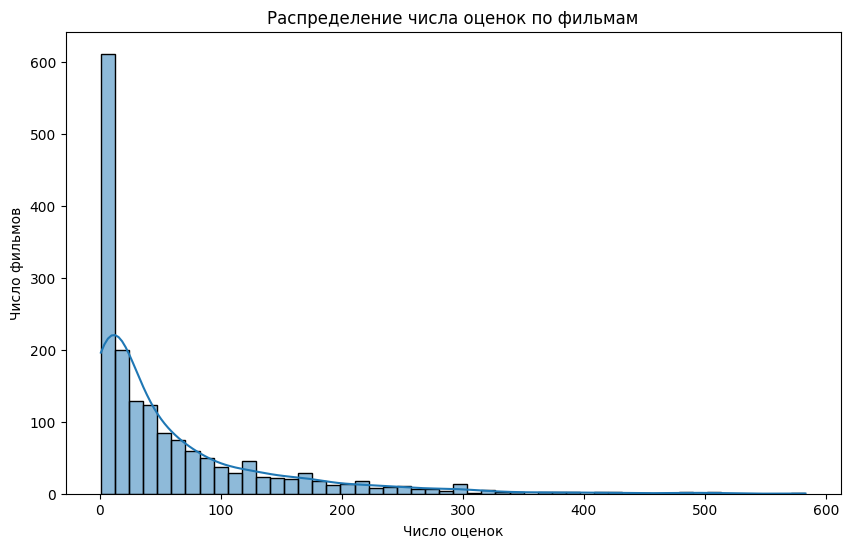

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = ratings

# Распределение оценок фильмов
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df)
plt.title('Распределение оценок фильмов')
plt.show()

# Распределение числа оценок по пользователям

# Распределение числа оценок по пользователям
plt.figure(figsize=(10, 6))
user_rating_counts = df['userid'].value_counts()
sns.histplot(user_rating_counts, bins=50, kde=True)

# Добавим линии для персентилей
percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = [user_rating_counts.quantile(p/100) for p in percentiles]
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

for p, val, color in zip(percentiles, percentile_values, colors):
    plt.axvline(x=val, linestyle='--', color=color, label=f'{p}th percentile')

plt.title('Распределение числа оценок по пользователям')
plt.xlabel('Число оценок')
plt.ylabel('Число пользователей')
plt.legend()
plt.show()

print(percentile_values)


# Распределение числа оценок по фильмам
plt.figure(figsize=(10, 6))
movie_rating_counts = df['itemid'].value_counts()
sns.histplot(movie_rating_counts, bins=50, kde=True)
plt.title('Распределение числа оценок по фильмам')
plt.xlabel('Число оценок')
plt.ylabel('Число фильмов')
plt.show()


Во избежание проблем с холодным стартом выберем пользователей с достаточно большим количеством фильмов (правее медианы).

In [ ]:
ratings, movies = ml100k.load()
my_data = {
	'userid': [944,944,944,944,944,944,944,944,944,944,944,944, 944],
 	'itemid': [1, 50, 95, 161, 195, 210, 222, 227, 228, 229, 274, 465, 449] ,
 	'rating': [5, 4,  5,  3,   4,   4,   5,   5,   5,   5,   4,   5,   5  ]
}


ds_new = pd.DataFrame(my_data)

ratings = ratings.append(ds_new, ignore_index=True)


<ipython-input-77-9076ab195da1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ratings = ratings.append(ds_new, ignore_index=True)


In [ ]:
ratings['userid'].max()

944

In [ ]:
ratings, uencoder, iencoder = ids_encoder(ratings)


In [ ]:
ratings['itemid'].max()

1681

In [ ]:
m_Jac = User2User_Jac().fit(ratings, False)
res_m_Jac = m_Jac.predict(943)
print(res_m_Jac)
res_m_Jac_correction = m_Jac.predict_with_correction(943)
print(res_m_Jac_correction)


  0%|          | 0/445096 [00:00<?, ?it/s]

[173 171 180  97 126 317  63  99 172  21]
[173 171 180  97 126 317  63  99 172 482]


In [ ]:
m_SP = User2User_SP().fit(ratings, False)
res_m_SP = m_SP.predict(943)
print(res_m_SP)
res_m_SP_correction = m_SP.predict_with_correction(943)
print(res_m_SP_correction)


  0%|          | 0/445096 [00:00<?, ?it/s]

[ 97  99 482  55  63 602 356 184 317 126]
[ 97 482  99  63  55 602 317 356 126 184]


In [ ]:
m_Cos = User2User_Cos().fit(ratings, False)
res_m_Cos = m_Cos.predict(943)
print(res_m_Cos)
res_m_Cos_correction = m_Cos.predict_with_correction(943)
print(res_m_Cos_correction)

  0%|          | 0/445096 [00:00<?, ?it/s]

neighbors in pred: [  3   4   7   9  16  17  18  20  22  26  29  37  45  48  56  57  63  69
  70  74  79  88  92  93  98 101 105 108 113 122 126 130 131 133 150 152
 156 157 158 159 160 164 166 167 179 180 182 183 184 186 187 189 192 199
 200 213 216 222 223 232 233 235 242 244 248 249 251 252 253 254 261 262
 264 268 270 274 275 276 284 285 286 287 293 295 306 315 317 326 329 336
 338 339 341 342 344 347 356 364 373 375 378 379 380 381 384 386 387 388
 389 395 397 400 401 402 406 410 416 436 440 444 448 457 463 465 467 468
 470 477 478 483 498 499 500 517 519 520 524 529 533 535 538 541 547 550
 553 558 566 574 577 582 589 590 593 604 607 611 613 619 620 626 634 638
 639 640 641 642 646 647 648 657 658 661 665 666 668 669 671 675 676 677
 681 683 685 689 690 691 696 701 707 715 717 718 730 742 743 750 752 756
 758 762 763 764 766 767 768 769 773 791 794 799 804 805 806 816 820 821
 828 832 839 842 846 847 850 853 859 861 863 869 871 878 879 880 886 887
 895 906 910 916 917 918 921 926

In [ ]:
m_Pearson = User2User_Pearson().fit(ratings, False)
res_m_Pearson = m_Pearson.predict(943)
print(res_m_Pearson)
res_m_Pearson_correction = m_Pearson.predict_with_correction(943)
print(res_m_Pearson_correction)

  0%|          | 0/445096 [00:00<?, ?it/s]

<ipython-input-150-7fd8d21e3f80>:39: RuntimeWarning: invalid value encountered in double_scalars
  return min(len(intersection_films)/50, 1 ) * np.sum(scores_left*scores_right)/np.sqrt( np.sum(scores_left**2) *  np.sum(scores_right**2))


neighbors in pred: [  3   4   7   9  16  17  20  22  29  37  48  56  57  63  69  70  74  88
  92  93  98 101 105 108 113 126 130 150 156 157 158 159 160 166 167 180
 182 183 187 192 199 200 213 216 222 232 233 235 244 248 249 252 253 261
 262 264 268 270 274 275 276 285 286 287 293 295 306 317 326 329 336 338
 339 341 342 344 356 364 373 378 379 380 384 386 388 395 397 400 401 402
 406 410 416 436 444 457 465 467 470 477 478 483 498 499 500 517 520 529
 533 535 541 547 550 553 558 566 593 604 607 619 620 626 638 639 641 642
 647 648 657 658 665 668 669 675 676 677 681 683 689 690 696 701 707 715
 717 718 730 743 750 752 756 758 762 763 764 766 767 768 769 773 794 799
 804 805 806 816 820 821 828 832 839 842 846 847 850 853 861 863 869 871
 878 879 880 886 895 906 910 916 917 918 921 926 929 931 935 937 939 941]
[ 97  99 482  63 317 126 356  55 172 602]
[ 97 482 317  99  63 126 356 173  55 172]


In [ ]:
movies.iloc[res_m_Jac]


,itemid,title
97,98,"Silence of the Lambs, The (1991)"
482,483,Casablanca (1942)
99,100,Fargo (1996)
63,64,"Shawshank Redemption, The (1994)"
55,56,Pulp Fiction (1994)
602,603,Rear Window (1954)
317,318,Schindler's List (1993)
356,357,One Flew Over the Cuckoo's Nest (1975)
126,127,"Godfather, The (1972)"
184,185,Psycho (1960)


In [ ]:
movies.iloc[res_m_Jac_correction]

,itemid,title
173,174,Raiders of the Lost Ark (1981)
171,172,"Empire Strikes Back, The (1980)"
180,181,Return of the Jedi (1983)
97,98,"Silence of the Lambs, The (1991)"
126,127,"Godfather, The (1972)"
317,318,Schindler's List (1993)
63,64,"Shawshank Redemption, The (1994)"
99,100,Fargo (1996)
172,173,"Princess Bride, The (1987)"
482,483,Casablanca (1942)


In [ ]:
movies.iloc[res_m_SP]

,itemid,title
97,98,"Silence of the Lambs, The (1991)"
99,100,Fargo (1996)
482,483,Casablanca (1942)
55,56,Pulp Fiction (1994)
63,64,"Shawshank Redemption, The (1994)"
602,603,Rear Window (1954)
356,357,One Flew Over the Cuckoo's Nest (1975)
184,185,Psycho (1960)
317,318,Schindler's List (1993)
126,127,"Godfather, The (1972)"


In [ ]:
movies.iloc[res_m_SP_correction]

,itemid,title
97,98,"Silence of the Lambs, The (1991)"
482,483,Casablanca (1942)
99,100,Fargo (1996)
63,64,"Shawshank Redemption, The (1994)"
55,56,Pulp Fiction (1994)
602,603,Rear Window (1954)
317,318,Schindler's List (1993)
356,357,One Flew Over the Cuckoo's Nest (1975)
126,127,"Godfather, The (1972)"
184,185,Psycho (1960)


In [ ]:
movies.iloc[res_m_Pearson_correction]

,itemid,title
97,98,"Silence of the Lambs, The (1991)"
482,483,Casablanca (1942)
317,318,Schindler's List (1993)
99,100,Fargo (1996)
63,64,"Shawshank Redemption, The (1994)"
126,127,"Godfather, The (1972)"
356,357,One Flew Over the Cuckoo's Nest (1975)
173,174,Raiders of the Lost Ark (1981)
55,56,Pulp Fiction (1994)
172,173,"Princess Bride, The (1987)"


###Разделите датасет movielens на тренировочную и валидационную части. Постройте рекомендации для пользователей из валидационной части (40 баллов)


In [ ]:
ratings, movies = ml100k.load()
my_data = {
	'userid': [944,944,944,944,944,944,944,944,944,944,944,944, 944],
 	'itemid': [1, 50, 95, 161, 195, 210, 222, 227, 228, 229, 274, 465, 449] ,
 	'rating': [5, 4,  5,  3,   4,   4,   5,   5,   5,   5,   4,   5,   5  ]
}


ds_new = pd.DataFrame(my_data)

ratings = ratings.append(ds_new, ignore_index=True)

ratings, uencoder, iencoder = ids_encoder(ratings)
user_rating_counts = ratings['userid'].value_counts()
selected_users = user_rating_counts[user_rating_counts > 65]
selected_users_20_percent = selected_users.sample(frac=0.4, random_state=42)
result_df = ratings[ratings['userid'].isin(selected_users_20_percent.index)]
validation_users =  result_df['userid'].unique()
validation_users

<ipython-input-59-8546ef723669>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ratings = ratings.append(ds_new, ignore_index=True)


array([  0,  20,  21,  23,  24,  25,  27,  37,  47,  48,  57,  58,  61,
        62,  63,  64,  72,  90,  91,  93, 100, 103, 108, 114, 115, 116,
       118, 120, 124, 143, 144, 159, 177, 183, 187, 192, 209, 212, 215,
       231, 232, 234, 238, 242, 245, 250, 252, 253, 263, 278, 285, 287,
       289, 290, 292, 293, 294, 295, 296, 302, 307, 310, 312, 314, 322,
       324, 325, 330, 331, 362, 369, 373, 377, 378, 379, 380, 382, 388,
       391, 392, 398, 404, 405, 406, 408, 415, 416, 436, 441, 446, 448,
       449, 451, 456, 457, 459, 471, 475, 486, 494, 496, 497, 498, 499,
       500, 513, 520, 522, 525, 531, 533, 534, 544, 558, 560, 561, 566,
       568, 578, 584, 585, 587, 590, 594, 605, 609, 614, 616, 621, 628,
       629, 633, 637, 644, 652, 653, 659, 660, 664, 665, 668, 675, 681,
       685, 689, 709, 714, 715, 730, 732, 740, 745, 750, 751, 757, 773,
       781, 794, 795, 804, 805, 814, 824, 825, 827, 829, 861, 863, 867,
       869, 870, 876, 879, 880, 888, 889, 893, 896, 898, 900, 90

In [ ]:
from sklearn.model_selection import train_test_split
cond =  (ratings['userid'].isin(validation_users ))
train_ds = ratings
valid_ds = pd.DataFrame(columns=train_ds.columns)

for user in validation_users:
  train_u_ds, valid_u_ds = train_test_split(ratings[ratings['userid'] == user], test_size = 0.2, random_state=42)
  train_ds = train_ds.drop(train_ds [train_ds['userid'] == user].index)
  train_ds = train_ds.append(train_u_ds, ignore_index=True)
  valid_ds = valid_ds.append(valid_u_ds, ignore_index=True)


<ipython-input-60-978c0b348fc8>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_ds = train_ds.append(train_u_ds, ignore_index=True)
<ipython-input-60-978c0b348fc8>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_ds = valid_ds.append(valid_u_ds, ignore_index=True)


In [ ]:
valid_ds

,userid,itemid,rating
0,0,30,3
1,0,116,3
2,0,79,4
3,0,127,4
4,0,196,5
...,...,...,...
6855,942,186,5
6856,942,131,3
6857,942,187,4
6858,942,793,3


In [ ]:
train_ds[ train_ds['userid'] == 943]

,userid,itemid,rating
66067,943,0,5
66068,943,49,4
66069,943,94,5
66070,943,160,3
66071,943,194,4
66072,943,209,4
66073,943,221,5
66074,943,226,5
66075,943,227,5
66076,943,228,5


In [ ]:
class User2User():
  def __init__(self, alpha = 0, *kw,**args):
    self.ds = None
    self.alpha = alpha
  def fit(self, ds = None, n_users = None, n_items = None, norm = True):
    if not n_users and not n_items:
       raise RuntimeError(f'rating_mtr == n_users == n_items == None')
    if not norm:
        ds = normalize_rating(ds)
        #userid 	itemid 	rating 	norm_rating
        ds = ds[['userid', 	'itemid', 'norm_rating']]
        #ds = ds.to_numpy()
    self.n_users = n_users
    self.n_items = n_items
    self.r_matrix = np.zeros((n_users, n_items))
    for row in ds.itertuples():
        self.r_matrix[row[1], row[2]] = row[3]
    self.ds = ds
    self.similarities = np.full((self.n_users, self.n_users), -1.0)
    np.fill_diagonal(self.similarities, 1)
    with tqdm.notebook.tqdm(total=self.n_users * (self.n_users - 1) // 2) as pbar:
        for i in range(self.n_users):
            for j in range(i + 1, self.n_users):
                sim = self.cacl_similarities(i, j )  #similarity_between_two(np_ratings, items[i], items[j])
                self.similarities[i,j] = sim
                self.similarities[j,i] = sim
                pbar.update()
    return self
  def cacl_similarities(self, i, j):
    raise NotImplementedError("Need to implement in children clase")
    pass
  def get_nearest_neighbors(self, user)-> np.array:
    idx = np.where(self.similarities[user] > self.alpha )
    return idx[0][idx[0] != user]

  def calc_sigma(self, items):
    return np.sqrt( np.sum((items - items.mean())**2)/len(items) )

  def predict (self, user, top_k = 10):
    if user >= self.n_users:
      raise RuntimeError(f'User {user} not in users')
    if top_k is None:
      get_id = False
    else:
      get_id = True
    neighbors = self.get_nearest_neighbors(user)
    user_items = np.where(self.r_matrix[user] > 0)
    r_vector = np.zeros(self.n_items)
    if len(neighbors) < 2:
      if len(neighbors) < 1:
        return None
      neighbor = neighbors[0]
      neighbor_items = np.where(self.r_matrix[neighbor] > 0) #self.ds[self.ds[:,0] == neighbor]
      neighbor_items =  neighbor_items[0][~np.isin(neighbor_items[0], user_items[0])]
      #print(f"neighbor_items {neighbor_items}")
      if len(neighbor_items) == 0:
        return None
      if len(neighbor_items) < 2:
        if not get_id:
          return neighbor_items[0][2] * (1 if self.similarities[user,neighbor] > 0 else -1  )
        return neighbor_items[0][1]
      r_vector[neighbor_items] += self.r_matrix[neighbor][neighbor_items]*self.similarities[user,neighbor]
      r_vector = r_vector/(self.similarities[user,neighbor] + np.finfo(float).tiny)
      # оценки для фильмов
      if not get_id:
        return r_vector
      if len(r_vector) < top_k:
        return np.argsort(r_vector)[::-1]
      return  np.argsort(r_vector)[-top_k:][::-1]

    for neighbor in neighbors:
      neighbor_items = np.where(self.r_matrix[neighbor] > 0)  #self.ds[self.ds[:,0] == neighbor]
      neighbor_items =  neighbor_items[0][~np.isin(neighbor_items[0], user_items[0])] #neighbor_items[ ~np.isin( neighbor_items[:,1], user_items)] #[:,2]
      r_vector[neighbor_items] += self.r_matrix[neighbor][neighbor_items]*self.similarities[user,neighbor]
    r_vector = r_vector/(np.sum(np.abs( self.similarities[user][neighbors])) + np.finfo(float).tiny)
    # оценки для фильмов
    if not get_id:
      return r_vector
    if len(r_vector) < top_k:
        return np.argsort(r_vector)[::-1]
    return  np.argsort(r_vector)[-top_k:][::-1]

  def predict_with_correction (self, user, top_k = 10 ):
    """
    top_k == None вернуть все рейтнигни
    """
    if top_k is None:
      get_id = False
    else:
      get_id = True
    if user >= self.n_users:
      raise RuntimeError(f'User {user} not in users')
    neighbors = self.get_nearest_neighbors(user)
    user_items = np.where(self.r_matrix[user] > 0)
    r_vector = np.zeros(self.n_items)
    if len(neighbors) < 2:
      if len(neighbors) < 1:
        return None
      neighbor = neighbors[0]
      neighbor_items = np.where(self.r_matrix[neighbor] > 0) #self.ds[self.ds[:,0] == neighbor]
      neighbor_items =  neighbor_items[0][~np.isin(neighbor_items[0], user_items[0])]
      if len(neighbor_items) == 0:
        return None
      if len(neighbor_items) < 2:
        if not get_id:
          return None #neighbor_items[0][2] * (1 if self.similarities[user,neighbor] > 0 else -1  ) + self.matrix[user].mean()
        return None #neighbor_items[0][1]
      r_vector[neighbor_items] += (self.r_matrix[neighbor][neighbor_items] - \
                      self.r_matrix[neighbor][self.r_matrix[neighbor] > 0].mean())*self.similarities[user,neighbor]/self.calc_sigma( self.r_matrix[neighbor][self.r_matrix[neighbor] > 0] )
      r_vector = r_vector/(self.similarities[user,neighbor] + np.finfo(float).tiny)
      r_vector += self.r_matrix[user][self.r_matrix[user] > 0].mean()
      # оценки для фильмов
      if not get_id:
        return r_vector
      if len(r_vector) < top_k:
        return np.argsort(r_vector)[::-1]
      return  np.argsort(r_vector)[-top_k:][::-1]

    for neighbor in neighbors:
      neighbor_items = np.where(self.r_matrix[neighbor] > 0)  #self.ds[self.ds[:,0] == neighbor]
      neighbor_items =  neighbor_items[0][~np.isin(neighbor_items[0], user_items[0])] #neighbor_items[ ~np.isin( neighbor_items[:,1], user_items)] #[:,2]
      r_vector[neighbor_items] += (self.r_matrix[neighbor][neighbor_items] - \
                      self.r_matrix[neighbor][self.r_matrix[neighbor] > 0].mean())*self.similarities[user,neighbor]/self.calc_sigma( self.r_matrix[neighbor][self.r_matrix[neighbor] > 0]  )
    r_vector = r_vector/(np.sum(np.abs( self.similarities[user][neighbors])) + np.finfo(float).tiny)
    r_vector += self.r_matrix[user][self.r_matrix[user] > 0].mean()
    # оценки для фильмов
    if not get_id:
      return r_vector
    if len(r_vector) < top_k:
        return np.argsort(r_vector)[::-1]
    return  np.argsort(r_vector)[-top_k:][::-1]


class User2User_SP(User2User):
  def fast_calc_similarities(self):
    similarities = self.r_matrix.dot( self.r_matrix.T)
    return similarities
  def fast_fit(self, ds, n_users, n_items):
    self.ds = ds
    self.n_users = n_users
    self.n_items = n_items
    self.r_matrix = np.zeros((n_users, n_items))
    for row in ds.itertuples():
      self.r_matrix[row[1], row[2]] = row[3]
    self.similarities = self.fast_calc_similarities()
    return self
  def cacl_similarities(self, i, j):
    return scalar_product(self.r_matrix[i], self.r_matrix[j])
  def get_nearest_neighbors(self, user)-> np.array:
    alpha = np.percentile(self.similarities[user], 55)
    idx = np.where(self.similarities[user] > self.alpha )
    return idx[0][idx[0] != user]

class User2User_Cos(User2User):
  def cacl_similarities(self, i, j):
    return cosine(self.r_matrix[i], self.r_matrix[j])
  def fast_calc_similarities(self):
    similarities = self.r_matrix.dot( self.r_matrix.T) + np.finfo(float).tiny
    norms = np.array([np.sqrt(np.diagonal(similarities))])
    return similarities / norms / norms.T
  def fast_fit(self, ds, n_user, n_items):
    self.ds = ds
    self.n_users = n_users
    self.n_items = n_items
    self.r_matrix = np.zeros((n_users, n_items))
    for row in ds.itertuples():
      self.r_matrix[row[1], row[2]] = row[3]
    self.similarities = self.fast_calc_similarities()
    return self

class User2User_Jac(User2User):
  '''jaccard_similarity'''
  def get_nearest_neighbors(self, user)-> np.array:
    alpha = np.percentile(self.similarities[user], 55)
    idx = np.where(self.similarities[user] > self.alpha )
    return idx[0][idx[0] != user]
  def cacl_similarities(self, i, j):
    return jaccard_similarity(np.where(self.r_matrix[i] > 0),  np.where(self.r_matrix[j] > 0))

class User2User_Pearson(User2User):
  '''pearson_sim'''
  def cacl_similarities(self, i, j):
    l_person_items = np.where( self.r_matrix[i] > 0)
    r_person_items = np.where( self.r_matrix[j] > 0)
    intersection_films = np.intersect1d(l_person_items, r_person_items)
    if len(intersection_films) < 2:
        return 0
    avg_scores_left = self.r_matrix[i][l_person_items].mean()
    avg_scores_right = self.r_matrix[j][r_person_items].mean()

    scores_left = self.r_matrix[i][intersection_films]  - avg_scores_left
    scores_right = self.r_matrix[j][intersection_films] - avg_scores_right

    res = min(len(intersection_films)/50.0, 1) * np.sum(scores_left*scores_right)/np.sqrt( np.sum(scores_left**2) *  np.sum(scores_right**2))
    #res = np.sum(scores_left*scores_right)/np.sqrt( np.sum(scores_left**2) *  np.sum(scores_right**2))
    return res


In [ ]:
n_users = len(uencoder.classes_)
n_items = len(iencoder.classes_)
SP_m = User2User_SP().fast_fit(train_ds, n_users, n_items)
Cos_m = User2User_Cos().fast_fit(train_ds, n_users, n_items)
Jac_m = User2User_Jac().fit(train_ds, n_users, n_items)
Pearson_m = User2User_Pearson().fit(train_ds, n_users, n_items)

  0%|          | 0/445096 [00:00<?, ?it/s]

  0%|          | 0/445096 [00:00<?, ?it/s]

<ipython-input-57-e88d31298afa>:238: RuntimeWarning: invalid value encountered in double_scalars
  res = np.sum(scores_left*scores_right)/np.sqrt( np.sum(scores_left**2) *  np.sum(scores_right**2))


In [ ]:
SP_m.predict_with_correction(0)

array([ 96, 316, 172,  62,  10, 179,  54, 170, 481, 355])

In [ ]:
def precision_top_k(pred:np.array, real:np.array, top_k = 10):
  if len(pred) < top_k:
    return np.sum(np.isin(pred,real))/top_k
  return np.sum(np.isin(pred[:top_k],real))/top_k
def test_precision_top_k():
  p = np.array([1,2,3,4,5,6,7,8,9,10,15, 203])
  r = np.array([1,2,3,4,5,61,71,81,91,101, 203, 11, 12, 15])
  print(precision_top_k(p, r, 10))
test_precision_top_k()
import numpy as np


0.5


In [ ]:
def find_opt_alpha(model, valid_ds, loss = precision_top_k):
  old_alpha = model.alpha
  mask = np.tri(model.n_users)
  sim = model.similarities[ mask == 0]
  alpha_tests = {}
  num_users = len(valid_ds['userid'].unique())
  start_alpha = np.percentile(sim, 50)
  for i in range(0,15):
    #alpha = start_alpha + start_alpha*i/100
    #model.alpha = alpha
    r = 0
    r_c = 0
    for user in valid_ds['userid'].unique():
      pred_items = model.predict(user)
      pred_items_cor = model.predict_with_correction(user)
      valid_items = valid_ds[valid_ds['userid'] == user]['itemid'].values
      #print(pred_items)
      try:
        r += loss(pred_items, valid_items, 10)
      except:
         r += 0
      try:
        r_c += loss(pred_items_cor, valid_items, 10)
      except:
        r_c += 0
    #alpha_tests[alpha] = (r/num_users, r_c/num_users)
    print( f"alpha : {r/num_users} {r_c/num_users}")
  model.alpha = old_alpha
  return alpha_tests

In [ ]:
def test_models(models, valid_ds, loss = precision_top_k):

  num_users = len(valid_ds['userid'].unique())
  for m in models:
    mask = np.tri(m.n_users)
    sim = m.similarities[ mask == 0]
    r = 0
    r_c = 0
    for user in valid_ds['userid'].unique():
      pred_items = m.predict(user)
      pred_items_cor = m.predict_with_correction(user)
      valid_items = valid_ds[valid_ds['userid'] == user]['itemid'].values
      #print(pred_items)
      try:
        r += loss(pred_items, valid_items, 10)
      except:
         r += 0
      try:
        r_c += loss(pred_items_cor, valid_items, 10)
      except:
        r_c += 0
    #alpha_tests[alpha] = (r/num_users, r_c/num_users)
    print( f"{m.__class__.__name__} : {r/num_users} {r_c/num_users}")

In [ ]:
#r = find_opt_alpha(SP_m, valid_ds)

models = [SP_m, Cos_m, Jac_m, Pearson_m]
test_models(models, valid_ds)


User2User_SP : 0.4016129032258064 0.29354838709677444
User2User_Cos : 0.4129032258064517 0.2983870967741938
User2User_Jac : 0.4236559139784946 0.29784946236559157
User2User_Pearson : 0.28817204301075283 0.2596774193548388


Соберем рекомендации

In [ ]:
def get_recomendations(models, user, movies):
	res = {}
	for model in models:
		p = model.predict(user)
		p_c = model.predict_with_correction(user)
		print(f"model: {model.__class__.__name__} simple:\n{movies['title'].iloc[p]} \n with_correction:\n {movies['title'].iloc[p_c]}")
		res[model.__class__.__name__] = (p, p_c)
	return res


In [ ]:
models = [SP_m, Cos_m, Jac_m, Pearson_m]
res = get_recomendations(models, 943, movies)

model: User2User_SP simple:
180           Return of the Jedi (1983)
173      Raiders of the Lost Ark (1981)
171     Empire Strikes Back, The (1980)
97     Silence of the Lambs, The (1991)
99                         Fargo (1996)
203           Back to the Future (1985)
172          Princess Bride, The (1987)
78                 Fugitive, The (1993)
120       Independence Day (ID4) (1996)
55                  Pulp Fiction (1994)
Name: title, dtype: object 
 with_correction:
 173      Raiders of the Lost Ark (1981)
171     Empire Strikes Back, The (1980)
97     Silence of the Lambs, The (1991)
180           Return of the Jedi (1983)
317             Schindler's List (1993)
63     Shawshank Redemption, The (1994)
172          Princess Bride, The (1987)
126               Godfather, The (1972)
482                   Casablanca (1942)
88                  Blade Runner (1982)
Name: title, dtype: object
model: User2User_Cos simple:
180           Return of the Jedi (1983)
173      Raiders of the Lost 

In [ ]:
#SP_m.ds[SP_m.ds['userid'] == 943]#[ SP_m.r_matrix[943] > 0]
SP_m.r_matrix[943]

array([3., 4., 3., ..., 0., 0., 5.])

In [ ]:
recomends_dict = {
  'SP_simpe' : [
[180,           'Return of the Jedi (1983)' ,1]
,[173,     'Raiders of the Lost Ark (1981)' ,1]
,[171,     'Empire Strikes Back, The (1980)' ,1]
,[97,    'Silence of the Lambs, The (1991)' ,0.5]
,[99 ,                        'Fargo (1996)' ,0.5]
,[203 ,          'Back to the Future (1985)' ,1]
,[172  ,        'Princess Bride, The (1987)' ,0.7]
,[78    ,             'Fugitive, The (1993)' ,0.5]
,[120    ,   'Independence Day (ID4) (1996)' ,0.7]
,[55     ,            'Pulp Fiction (1994)' ,0.2]
],
'SP_simpe_with_correction' : [
[173, 'Raiders of the Lost Ark (1981) ', 1]
,[171, 'Empire Strikes Back The (1980) ', 1]
,[97, 'Silence of the Lambs The (1991) ', 0.5]
,[180, 'Return of the Jedi (1983)', 1]
,[317, "Schindler's List (1993) ", 0.7]
,[63, 'Shawshank Redemption The (1994) ', 0.7]
,[172, 'Princess Bride The (1987) ', 0.7]
,[126, 'Godfather, The (1972) ', 0.7]
,[482, 'Casablanca (1942) ', 0]
,[88, 'Blade Runner (1982)', 0.5]
],
'Jac_simple' : [
[180,'Return of the Jedi (1983)' ,1]
,[173,"Raiders of the Lost Ark (1981)" ,1]
,[99,"Fargo (1996)" ,0.5]
,[171,"Empire Strikes Back, The (1980)" ,1]
,[257,                      "Contact (1997)" ,0.5]
,[126,               "Godfather, The (1972)" ,0.7]
,[97,     "Silence of the Lambs, The (1991)" ,0.5]
,[120,       "Independence Day (ID4) (1996)" ,0.7]
,[6,                 "Twelve Monkeys (1995)" ,0.4]
,[55,                  "Pulp Fiction (1994)" ,0.2]
],
'Jac_with_correction' : [
[173,      "Raiders of the Lost Ark (1981)" ,1]
,[171,     "Empire Strikes Back, The (1980)" ,1]
,[180,           "Return of the Jedi (1983)" ,1]
,[97,     "Silence of the Lambs, The (1991)" ,0.5]
,[317,             "Schindler's List (1993)" ,0.7]
,[126,              "Godfather, The (1972)" ,0.7]
,[63,     "Shawshank Redemption, The (1994)" ,0.7]
,[99,                         "Fargo (1996)" ,0.5]
,[172,          "Princess Bride, The (1987)" ,0.7]
,[482,                   "Casablanca (1942)" ,0]
],

'Pearson_simple' : [
[99,                                     "Fargo (1996)" ,0.5]
,[97,                 "Silence of the Lambs, The (1991)" ,0.5]
,[173,                  "Raiders of the Lost Ark (1981)" ,1]
,[236,                           "Jerry Maguire (1996)" ,0.2]
,[116,                                "Rock, The (1996)" ,0.6]
,[120,                   "Independence Day (ID4) (1996)" ,0.7]
,[55,                              "Pulp Fiction (1994)" ,0.2]
,[126,                           "Godfather, The (1972)" ,0.7]
,[6,                             "Twelve Monkeys (1995)" ,0.4]
,[150,    "Willy Wonka and the Chocolate Factory (1971)" ,0.8]
],

'pearson_with_correction' :[
[99,                               "Fargo (1996)" ,0.5]
,[97,           "Silence of the Lambs, The (1991)" ,0.5]
,[317,                   "Schindler's List (1993)" ,0.7]
,[63,           "Shawshank Redemption, The (1994)" ,0.7]
,[126,                     "Godfather, The (1972)" ,0.7]
,[55,                        "Pulp Fiction (1994)" ,0.2]
,[482,                         "Casablanca (1942)" ,0]
,[426,              "To Kill a Mockingbird (1962)" ,0.2]
,[602,                        "Rear Window (1954)" ,0.2]
,[356,    "One Flew Over the Cuckoo's Nest (1975)" ,0.5]
]
}

In [ ]:
from sklearn.metrics import ndcg_score, dcg_score
def calc_ndcg(preds):
  print('NDCG:')
  for key in preds:
    df = pd.DataFrame(preds[key], columns = ['id','name','rel'])
    r = np.asarray([df['rel'].values])
    t = np.asarray([ np.sort(df['rel'].values)[::-1] ])
    r = ndcg_score(t, r)
    print(f"{key}:{r}")
  print()
  print('Cредняя релевантность:')
  for key in preds:
     df = pd.DataFrame(preds[key], columns = ['id','name','rel'])
     print( f"{key}: {np.sum( df['rel'].values )/len(df['rel'].values)}")

In [ ]:
calc_ndcg(recomends_dict)

NDCG:
SP_simpe:0.9670475301371149
SP_simpe_with_correction:0.9588125751726099
Jac_simple:0.9580080928833397
Jac_with_correction:0.9960779872815764
Pearson_simple:0.844669610250604
pearson_with_correction:0.9248605336958741

Cредняя релевантность:
SP_simpe: 0.7100000000000001
SP_simpe_with_correction: 0.6799999999999999
Jac_simple: 0.6500000000000001
Jac_with_correction: 0.6799999999999999
Pearson_simple: 0.56
pearson_with_correction: 0.42000000000000004


## Часть 4
###Общее
Самый большой показатель NDCG у user-base коллаборативной фильтрации на основе метрики близости Жаккара с нормализацией при усреднении равный 0.9974536526321872, что является почти идеальным показателем. В свою очередь, самая высокая средняя релевантность тоже у user-base коллаборативной фильтрации на основе метрики близости Жаккара с нормализацией.


### Скалярное произведение общих рейтингов
Рекомендации слишком чувствительны к абсолютным оценкам пользователей, есть склонность давать популярные рекомендации, очень большой разброс близости пользователей.
#### Простое усреднение по ближайшим соседям
В целом у метода хорошо получилось уловить любовь к "Звёздным войнам" и уловить "приключенческую составляющую" в предпочтениях, но в тоже время по настоящему персональными рекомендациями можно назвать только 5 фильмов из 10. В остальном приводились просто хорошие популярные фильмы с элементами приключений. Показал хороший показатель MAP@10:0.4016129032258064.
#### Усреднение с учетом коррекции среднего
Тоже хорошо смог уловить любовь к "Звёздным войнам" и жанровую принадлежность, но все еще крайне склонен давать просто популярные фильмы в рамках жанра, так по настоящему персональными рекомендациями можно назвать только 4 фильма из 10,
MAP@10 довольно низкий: 0.29354838709677444.


### Скорректированная Корреляция Пирсона


Не так чувствительна к абсолютным оценкам, но плохо подходит для пользователей с малым количеством оцененных фильмов, особенно с коррекцией на малое количество фильмов. Учитывая, что у 50\% пользователей меньше 65 оценок, то результат закономерный. По итогу выдает довольно общие рекомендации.
#### Простое усреднение по ближайшим соседям
Показал самый худший результат ранжирования.
#### Усреднение с учетом коррекции среднего
Хоть сами рекомендации получились не самые релевантные (возможно из-за плохо подобранного значения $\alpha$), показатель ранжирования довольно хороший.


### Коэффициент Жаккара


Метод хорошо проявил себя на малом числе рекомендаций и выдал один из лучших MAP@10. Из явных недостатков, не учитывает значение оценки в принципе и просто пытается порекомендовать то, что мы уже смотрели независимо от того, понравилось нам или нет. Будет плохо себя проявлять в перспективе, так как рекомендации будут иметь тенденцию размазываться.
#### Простое усреднение по ближайшим соседям
В целом хорошо смог считать жанровые предпочтения для моих рекомендаций, так как там были в основном позитивные примеры. В общем случае не отличает похожих пользователей и тех, что просто смотрели одни фильмы.
#### Усреднение с учетом коррекции среднего
Фильмы лучше проранжированы и в целом получились одними из самых релевантных.

